In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import random
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping
import csv
import os,random


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.layers import Input,Masking, LSTM, Dense


import datetime
now = datetime.datetime.now

! pip install numpy scikit-learn imbalanced-learn


In [ ]:
X_correct = np.load('/content/drive/MyDrive/Project_wrk/correct_data_3d.npy')
X_incorrect = np.load('/content/drive/MyDrive/Project_wrk/incorrect_data_3d.npy')

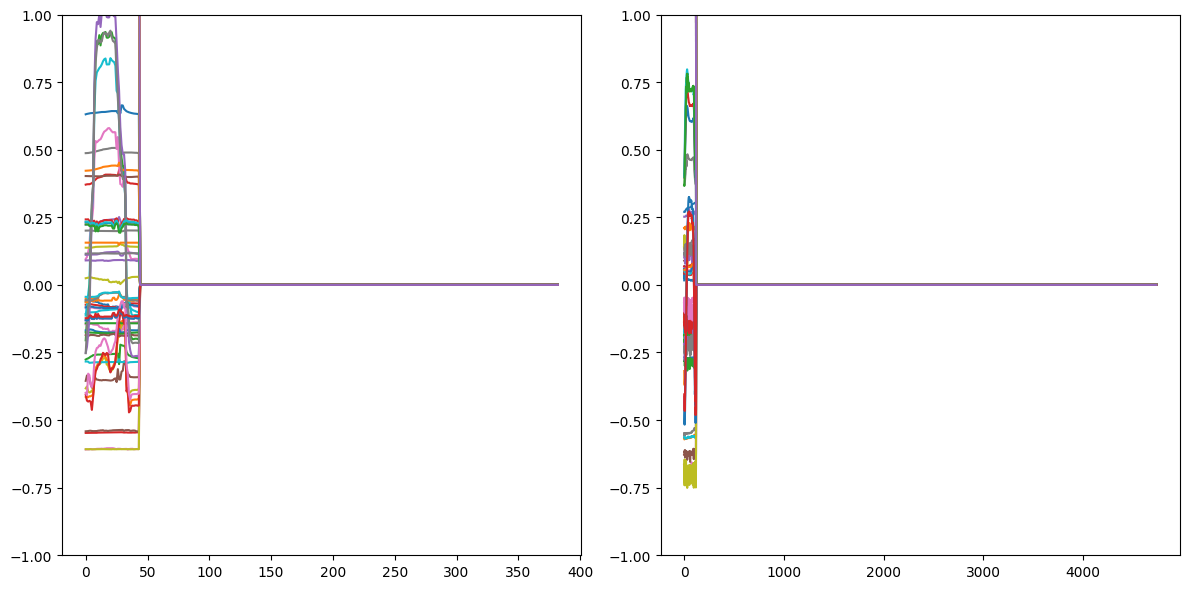

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(X_correct[0])
plt.ylim([-1,1])
plt.subplot(1,2,2)
plt.plot(X_incorrect[0])
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

In [ ]:

#setting the max_frames for both the correct and incorrect sequences as 500 for padding and truncating---then compare results
#I want to confirm if this is the right wau=y to padd and truncate the num of frames arrays
#!pip install keras==2.9
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to create 3D array with padding for correct sequences and truncation for incorrect sequences
def create_3d_array(data_arrays_list, max_frames=500):
    num_files = len(data_arrays_list)
    # Assuming all sequences have the same number of joints, take the number of joints from the first frame of the first sequence
    num_joints = len(data_arrays_list[0][0])

    # Initialize a 3D array with zeros
    data_3d = np.zeros((num_files, max_frames, num_joints))

    for i, sequence in enumerate(data_arrays_list):
        # Initialize a temporary list to store padded data for each joint
        padded_sequence = []

        for joint in range(num_joints):
            # Extract the joint data for the entire sequence
            joint_data = np.array([frame[joint] for frame in sequence])

            # Pad or truncate the joint data
            joint_padded = pad_sequences([joint_data], maxlen=max_frames, dtype='float32', padding='post', truncating='post')

            # Add the padded joint data to the temporary list
            padded_sequence.append(joint_padded[0])

        # Stack the padded data for all joints to form the final padded sequence
        data_3d[i] = np.stack(padded_sequence, axis=-1)

    return data_3d



# Create 3D arrays with padding for correct and truncation for incorrect
correct_data_3d = create_3d_array(X_correct)
incorrect_data_3d = create_3d_array(X_incorrect)

In [ ]:
n_dim = 75
num_frames = 500

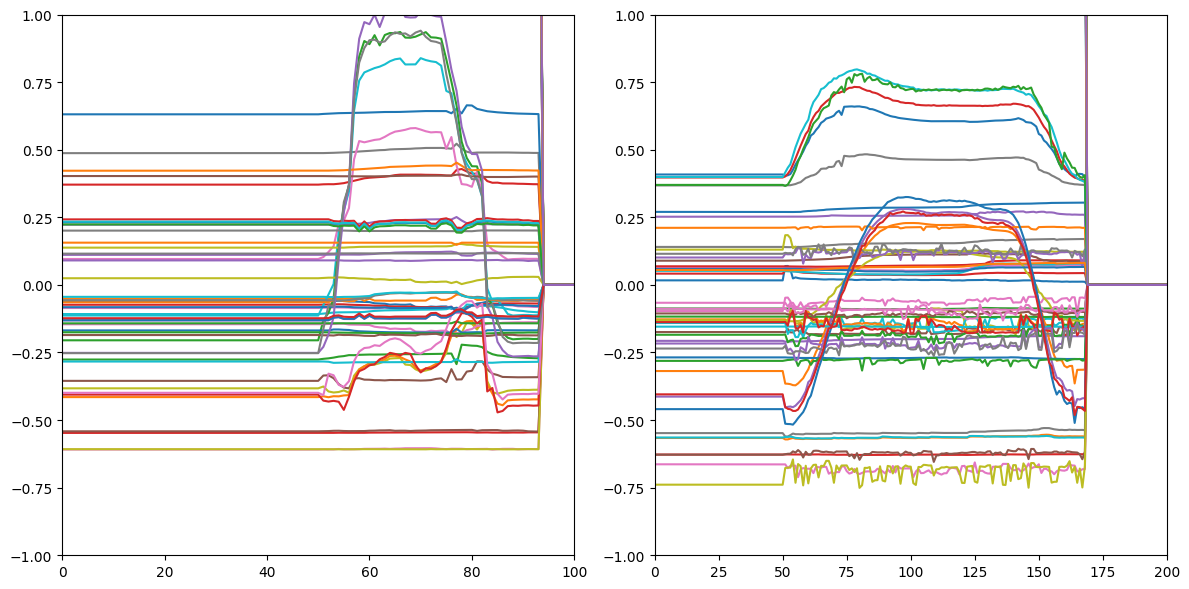

In [ ]:
# Add 50 time frames at the beginning and end of sequences
# The autoencoder has difficulties with the beginning and ending frames
data_correct = np.zeros((correct_data_3d.shape[0],num_frames+100,n_dim))
for i in range(X_correct.shape[0]):
    data_correct[i,:,:] = np.concatenate((np.concatenate((np.tile(correct_data_3d[i,0,:],[50, 1]), correct_data_3d[i,:,:])), np.tile(correct_data_3d[i,-1,:],[50, 1])))

data_incorrect = np.zeros((incorrect_data_3d.shape[0],num_frames+100,n_dim))
for i in range(X_incorrect.shape[0]):
    data_incorrect[i,:,:] = np.concatenate((np.concatenate((np.tile(incorrect_data_3d[i,0,:],[50, 1]), incorrect_data_3d[i,:,:])), np.tile(incorrect_data_3d[i,-1,:],[50, 1])))

# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(data_correct[0])
plt.ylim([-1,1])
plt.xlim([0,100])
plt.subplot(1,2,2)
plt.plot(data_incorrect[0])
plt.ylim([-1,1])
plt.xlim([0,200])
plt.tight_layout()
plt.show()

In [ ]:
# Encoder layers
input_seq = Input(shape=(num_frames+100,n_dim))
encoded1 = LSTM(30,return_sequences = True)(input_seq)
encoded2 = LSTM(10,return_sequences = True)(encoded1)
# Encoded representation of the input, 340x4 vector
encoded = LSTM(4,return_sequences = True)(encoded2)
# Decoder layers
decoded1 = LSTM(10,return_sequences = True)(encoded)
decoded2 = LSTM(30,return_sequences = True)(decoded1)
decoded = LSTM(n_dim, return_sequences = True)(decoded2)

# The model maps an input to its reconstruction
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600, 75)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 600, 30)           12720     
                                                                 
 lstm_7 (LSTM)               (None, 600, 10)           1640      
                                                                 
 lstm_8 (LSTM)               (None, 600, 4)            240       
                                                                 
 lstm_9 (LSTM)               (None, 600, 10)           600       
                                                                 
 lstm_10 (LSTM)              (None, 600, 30)           4920      
                                                                 
 lstm_11 (LSTM)              (None, 600, 75)           31800 

In [ ]:
# Shuffle the sequences to create a training and validation sets
import random
trainidx = random.sample(range(0,data_correct.shape[0]),63)
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
train_data = data_correct[trainidx,:,:]
valid_data = data_correct[valididx,:,:]


In [ ]:
# Train an autoencoder on the correct data sequences
batch_size = 10
# Measure the training time
t = now()

# Request to stop before reaching the number of epochs if the validation loss does not decrease for 1000 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 10)

history = autoencoder.fit(train_data, train_data, epochs = 100, batch_size = batch_size, shuffle=True,
                validation_data=(valid_data, valid_data), verbose = 2, callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Epoch 1/100
7/7 - 1s - loss: 0.1392 - val_loss: 0.1451 - 1s/epoch - 191ms/step
Epoch 2/100
7/7 - 2s - loss: 0.1390 - val_loss: 0.1450 - 2s/epoch - 283ms/step
Epoch 3/100
7/7 - 1s - loss: 0.1388 - val_loss: 0.1450 - 1s/epoch - 210ms/step
Epoch 4/100
7/7 - 1s - loss: 0.1388 - val_loss: 0.1452 - 1s/epoch - 195ms/step
Epoch 5/100
7/7 - 1s - loss: 0.1388 - val_loss: 0.1448 - 1s/epoch - 187ms/step
Epoch 6/100
7/7 - 1s - loss: 0.1386 - val_loss: 0.1446 - 962ms/epoch - 137ms/step
Epoch 7/100
7/7 - 1s - loss: 0.1385 - val_loss: 0.1444 - 1s/epoch - 144ms/step
Epoch 8/100
7/7 - 1s - loss: 0.1385 - val_loss: 0.1444 - 1000ms/epoch - 143ms/step
Epoch 9/100
7/7 - 1s - loss: 0.1386 - val_loss: 0.1446 - 970ms/epoch - 139ms/step
Epoch 10/100
7/7 - 1s - loss: 0.1383 - val_loss: 0.1442 - 987ms/epoch - 141ms/step
Epoch 11/100
7/7 - 1s - loss: 0.1381 - val_loss: 0.1442 - 1s/epoch - 145ms/step
Epoch 12/100
7/7 - 1s - loss: 0.1381 - val_loss: 0.1441 - 988ms/epoch - 141ms/step
Epoch 13/100
7/7 - 1s - loss: 0.1

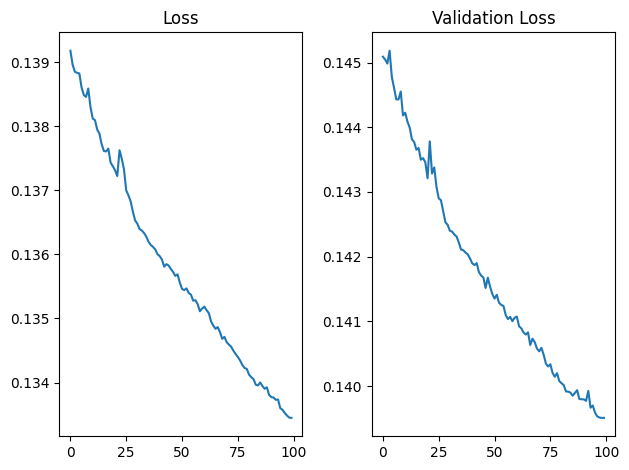

0.1334487348794937
0.1395101547241211


In [ ]:
# Plot the training and validation results
plt.figure(1)
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the resulting training and validation loss values
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

64/64 [==============================] - 18s 65ms/step


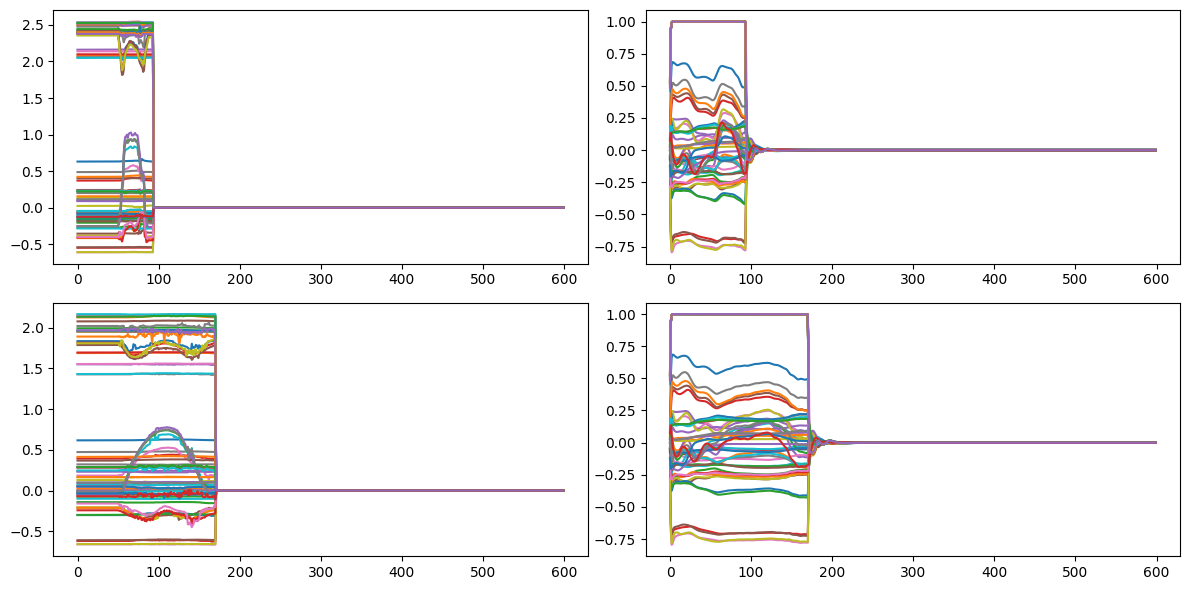

In [ ]:
# Encode and decode sequences to check the model performance
decoded_seqs = autoencoder.predict(data_correct)
# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])

    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
plt.tight_layout()
plt.show()

64/64 [==============================] - 3s 34ms/step


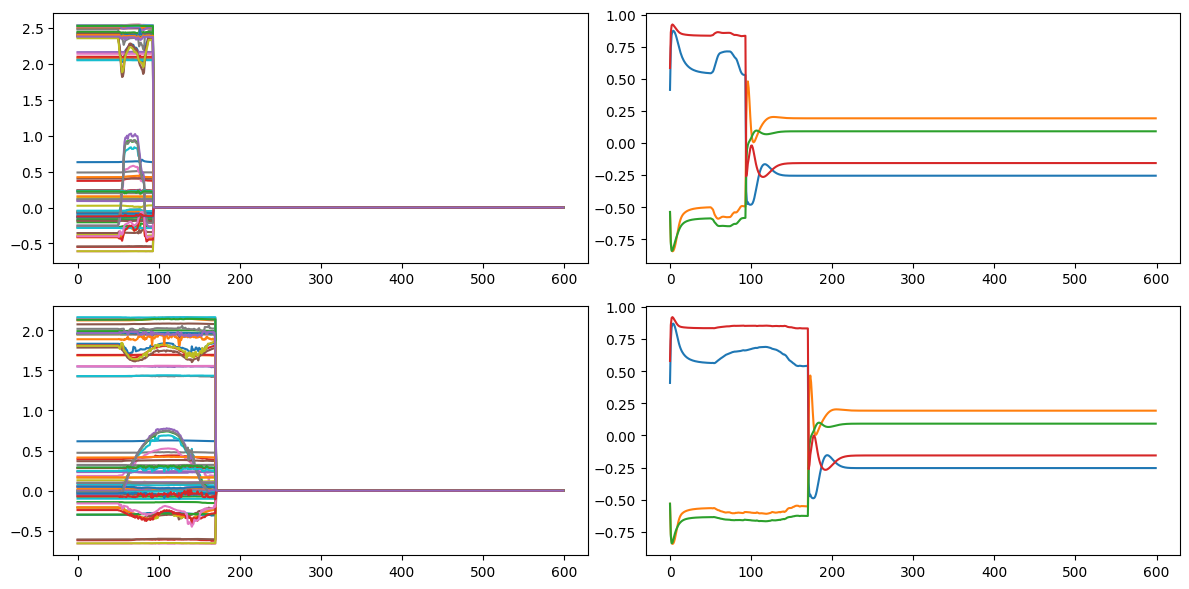

In [ ]:
# Create an encoder model, that maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(data_correct)

# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data_correct[i])

    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
plt.tight_layout()
plt.show()

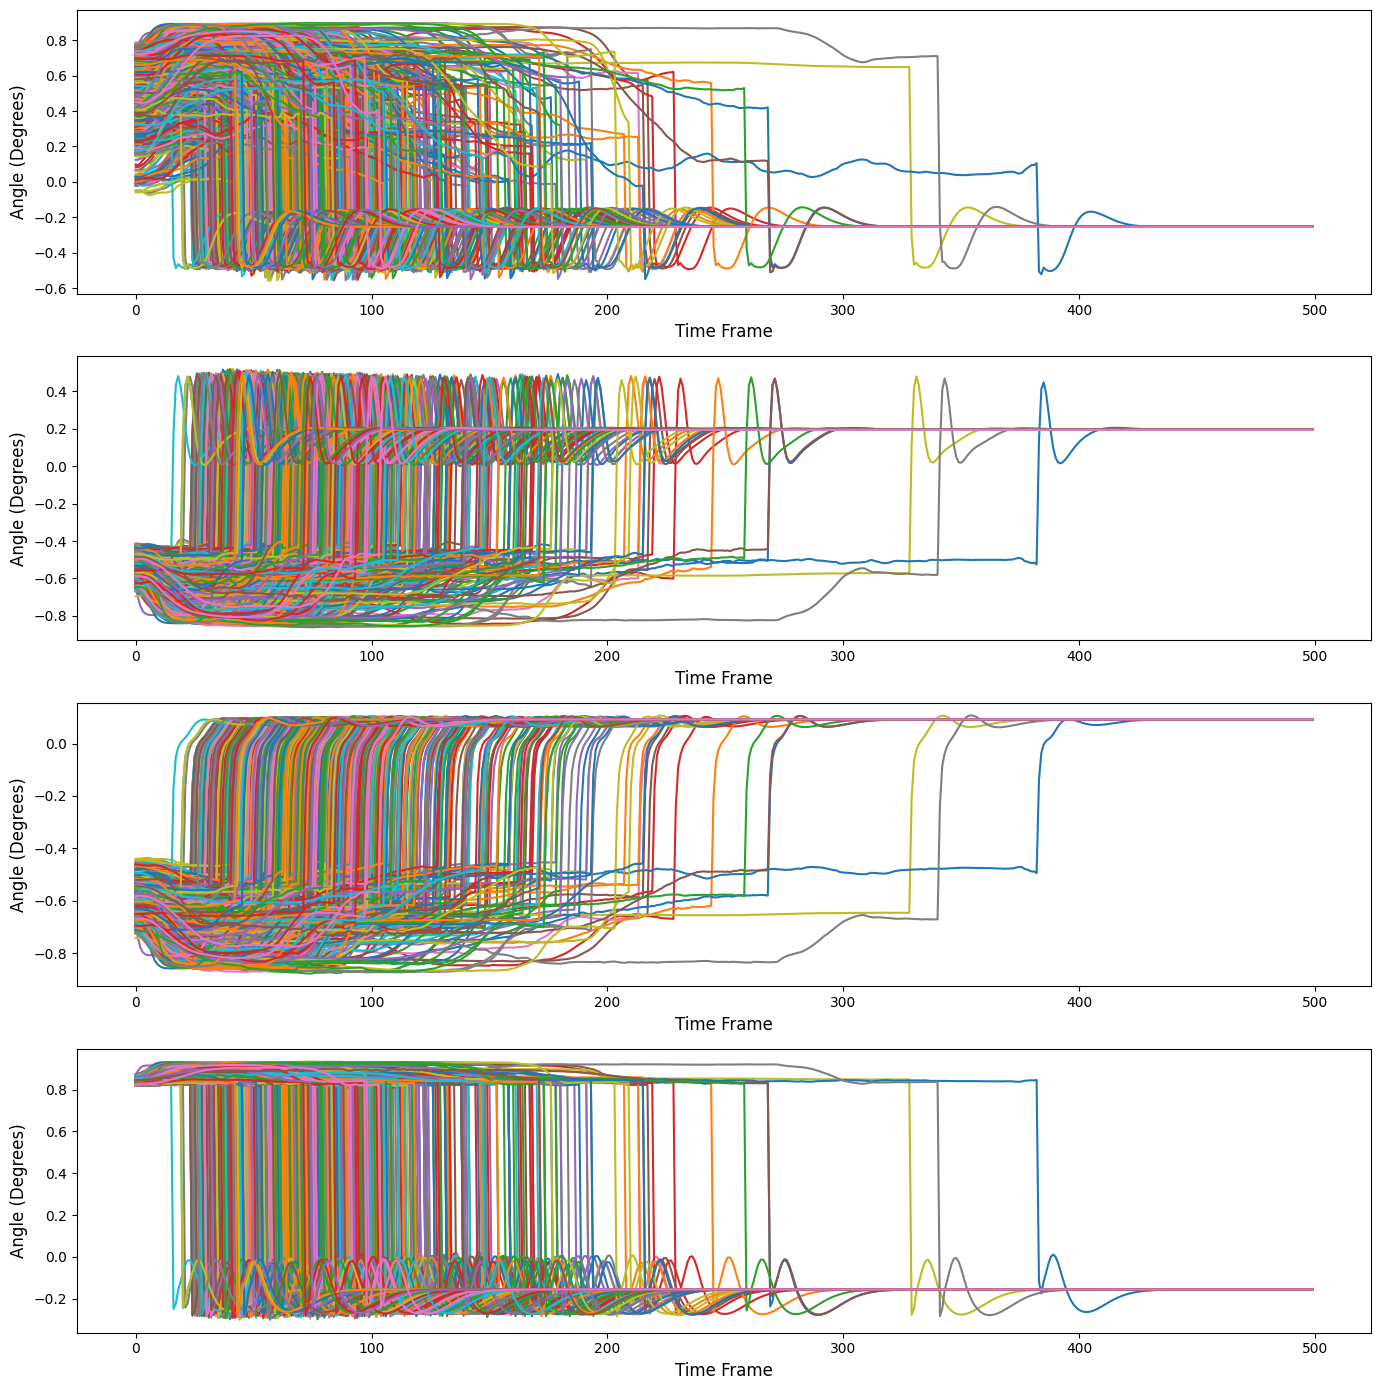

In [ ]:
# Plot all encoded sequences without the first and last 50 time frames
plt.figure(figsize = (14,14))
for i in range(data_correct.shape[0]):
    plt.subplot(4,1,1)
    plt.plot(encoded_seqs[i,50:-50,0])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,2)
    plt.plot(encoded_seqs[i,50:-50,1])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,3)
    plt.plot(encoded_seqs[i,50:-50,2])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,4)
    plt.plot(encoded_seqs[i,50:-50,3])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Remove the added first and last 50 frames
encoded_seqs = encoded_seqs[:,50:-50,:]

print(encoded_seqs.shape, 'encoded sequences shape')
# Reshape the encoded sequences, because savetxt saves two dimensional data
seqs = encoded_seqs.reshape(encoded_seqs.shape[0],encoded_seqs.shape[1]*encoded_seqs.shape[2])
print(seqs.shape, 'encoded sequences shape for saving')
# Save the data in the file 'Autoencoder_Output_Correct.csv'
np.savetxt('Autoencoder_Output_Correct.csv', seqs, fmt='%.5f',delimiter=',')

(2047, 500, 4) encoded sequences shape
(2047, 2000) encoded sequences shape for saving


In [ ]:
# Reduce the dimensionality of the incorrect sequences
encoded_seqs_incorrect = encoder.predict(data_incorrect)

17/17 [==============================] - 1s 41ms/step


In [ ]:
# Remove the added first and last 50 frames
encoded_seqs_incorrect = encoded_seqs_incorrect[:,50:-50,:]

print(encoded_seqs_incorrect.shape, 'encoded incorrect sequences shape')
# Reshape the encoded sequences, because savetxt saves only tow dimensional data
seqs_incorrect = encoded_seqs_incorrect.reshape(encoded_seqs_incorrect.shape[0],encoded_seqs_incorrect.shape[1]*encoded_seqs_incorrect.shape[2])
print(seqs_incorrect.shape, 'encoded incorrect sequences shape for saving')
# Save the incorrect data in the file 'Autoencoder_Output_Incorrect.csv'
np.savetxt('Autoencoder_Output_Incorrect.csv', seqs_incorrect, fmt='%.5f',delimiter=',')

(543, 500, 4) encoded incorrect sequences shape
(543, 2000) encoded incorrect sequences shape for saving
